In [ ]:
import numpy as np
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from scipy.special import softmax
import multiprocessing as mp
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch
from torch.nn import functional as F
from sklearn.preprocessing import normalize

# Installing ProdLDA
**Restart notbook after the installation!!**

In [ ]:
!git clone https://github.com/estebandito22/PyTorchAVITM

fatal: destination path 'PyTorchAVITM' already exists and is not an empty directory.


# 1. Creation of synthetic corpus

We consider a scenario with n parties, each of them as an associated corpus.
To generate the corpus associated with each of the parties, we consider a common beta distribution (word-topic distribution), but we freeze different topics/ assign different asymmetric Dirichlet priors favoring different topics at the time of generating the document that composes each party's corpus.

## 1.1. Function for permuting the Dirichlet prior at each node

In [ ]:
def rotateArray(arr, n, d):
    temp = []
    i = 0
    while (i < d):
        temp.append(arr[i])
        i = i + 1
    i = 0
    while (d < n):
        arr[i] = arr[d]
        i = i + 1
        d = d + 1
    arr[:] = arr[: i] + temp
    return arr

## 1.2. Topic modeling and node settings

In [ ]:
# Topic modeling settings
vocab_size = 100000
n_topics = 10
beta = 1e-2
alpha = 5/n_topics
n_docs = 1000
nwords = (150, 450) #Min and max lengths of the documents

# Nodes settings
n_nodes = 5
frozen_topics = 3
dirichlet_symmetric = False
prior = (n_topics)*[0.9]
prior[0] = prior[1] = prior[2] = 0.1
print(prior)

[0.1, 0.1, 0.1, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9]


## 1.3. Topics generation (common for all nodes)

In [ ]:
topic_vectors = np.random.dirichlet(vocab_size*[beta], n_topics)
print('Ordered probabilities for the first topic vector:')
print(np.sort(topic_vectors[0])[::-1])
print(topic_vectors.shape)

Ordered probabilities for the first topic vector:
[0.00711694 0.00572281 0.00389193 ... 0.         0.         0.        ]
(10, 100000)


## 1.4. Generation of document topic proportions and documents for each node


In [ ]:
doc_topics_all_gt = []
documents_all = []
z_all = []
for i in np.arange(n_nodes):
  # Step 2 - generation of document topic proportions for each node
  if dirichlet_symmetric:
    doc_topics = np.random.dirichlet((n_topics)*[alpha], n_docs)
  else:
    doc_topics = np.random.dirichlet(prior, n_docs)
    prior = rotateArray(prior, len(prior), 3)
    print(prior)
  print('Ordered probabilities for the first document - node', str(i), ':')
  print(np.sort(doc_topics[0])[::-1])
  doc_topics_all_gt.append(doc_topics)
  # Step 3 - Document generation
  documents = [] # Document words
  z = [] # Assignments
  for docid in np.arange(n_docs):
      doc_len = np.random.randint(low=nwords[0], high=nwords[1])
      this_doc_words = []
      this_doc_assigns = []
      for wd_idx in np.arange(doc_len):
          tpc = np.nonzero(np.random.multinomial(1, doc_topics[docid]))[0][0]
          this_doc_assigns.append(tpc)
          word = np.nonzero(np.random.multinomial(1, topic_vectors[tpc]))[0][0]
          this_doc_words.append('wd'+str(word))
      z.append(this_doc_assigns)
      documents.append(this_doc_words)
  print("Documents of node", str(i), "generated.")
  documents_all.append(documents)
  z_all.append(z)

[0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.1, 0.1, 0.1]
Ordered probabilities for the first document - node 0 :
[3.44398730e-01 1.76608353e-01 1.70387784e-01 1.17373755e-01
 6.67641489e-02 5.69683300e-02 5.59294510e-02 1.15676443e-02
 1.21642189e-06 5.86917333e-07]
Documents of node 0 generated.
[0.9, 0.9, 0.9, 0.9, 0.1, 0.1, 0.1, 0.9, 0.9, 0.9]
Ordered probabilities for the first document - node 1 :
[5.09346602e-01 1.71117209e-01 1.25407078e-01 9.24361646e-02
 3.81628904e-02 3.57772883e-02 1.62029425e-02 1.14497905e-02
 1.00032353e-04 2.51669525e-09]
Documents of node 1 generated.
[0.9, 0.1, 0.1, 0.1, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9]
Ordered probabilities for the first document - node 2 :
[4.39542106e-01 1.65667800e-01 1.39576423e-01 1.23151237e-01
 1.02892621e-01 2.35773240e-02 3.95942316e-03 1.63306583e-03
 1.53217114e-10 1.79600378e-11]
Documents of node 2 generated.
[0.1, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.1, 0.1]
Ordered probabilities for the first document - node 3 :
[3.36677744e-01 2

# 2. Preprocessing, generation of training dataset and training of a ProdLDA model at each node

In [ ]:
ls

call_signature.png  LICENSE.md  pytorchavitm/  README.md  train_abs.py
data/               outputs/    PyTorchAVITM/  setup.py   train.py


In [ ]:
cd /content/PyTorchAVITM/pytorchavitm/datasets

/content/PyTorchAVITM/pytorchavitm/datasets


In [ ]:
from bow import BOWDataset

In [ ]:
cd /content/PyTorchAVITM

/content/PyTorchAVITM


In [ ]:
from pytorchavitm import AVITM

In [ ]:
train_datasets = []
avitms = []
id2tokens = []
for corpus_node in documents_all:
  cv = CountVectorizer(input='content', lowercase=True, stop_words='english',
                      max_df=0.99, min_df=0.01, binary=False)
  
  docs = [" ".join(corpus_node[i]) for i in np.arange(len(corpus_node))]

  train_bow = cv.fit_transform(docs)
  train_bow = train_bow.toarray()

  idx2token = cv.get_feature_names()
  input_size = len(idx2token)

  id2token = {k: v for k, v in zip(range(0, len(idx2token)), idx2token)}
  id2tokens.append(id2token)

  train_data = BOWDataset(train_bow, idx2token)

  avitm = AVITM(input_size=input_size, n_components=10, model_type='prodLDA',
                hidden_sizes=(100, 100), activation='softplus', dropout=0.2,
                learn_priors=True, batch_size=64, lr=2e-3, momentum=0.99,
                solver='adam', num_epochs=100, reduce_on_plateau=False)

  avitm.fit(train_data)
  avitms.append(avitm)

  train_datasets.append(train_data)

Settings: 
               N Components: 10
               Topic Prior Mean: 0.0
               Topic Prior Variance: 0.9
               Model Type: prodLDA
               Hidden Sizes: (100, 100)
               Activation: softplus
               Dropout: 0.2
               Learn Priors: True
               Learning Rate: 0.002
               Momentum: 0.99
               Reduce On Plateau: False
               Save Dir: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Epoch: [1/100]	Samples: [1000/100000]	Train Loss: 2229.798765625	Time: 0:00:00.565321
Epoch: [2/100]	Samples: [2000/100000]	Train Loss: 2226.567578125	Time: 0:00:00.552588
Epoch: [3/100]	Samples: [3000/100000]	Train Loss: 2217.1238671875	Time: 0:00:00.509343
Epoch: [4/100]	Samples: [4000/100000]	Train Loss: 2203.455125	Time: 0:00:00.537650
Epoch: [5/100]	Samples: [5000/100000]	Train Loss: 2193.437578125	Time: 0:00:00.532242
Epoch: [6/100]	Samples: [6000/100000]	Train Loss: 2183.402515625	Time: 0:00:00.538233
Epoch: [7/100]	Samples: [7000/100000]	Train Loss: 2172.00878125	Time: 0:00:00.547806
Epoch: [8/100]	Samples: [8000/100000]	Train Loss: 2165.48378125	Time: 0:00:00.546911
Epoch: [9/100]	Samples: [9000/100000]	Train Loss: 2160.392609375	Time: 0:00:00.556588
Epoch: [10/100]	Samples: [10000/100000]	Train Loss: 2150.20146875	Time: 0:00:00.525687
Epoch: [11/100]	Samples: [11000/100000]	Train Loss: 2142.908921875	Time: 0:00:00.520013
Epoch: [12/100]	Samples: [12000/100000]	Train Loss: 214

# 2.1 Topics at each node

In [ ]:
topics_all = []
for node in np.arange(n_nodes):
  topics = pd.DataFrame(avitm.get_topics(10)).T
  topics_all.append(topics)
topics_all[0]

,0,1,2,3,4,5,6,7,8,9
0,wd92318,wd85632,wd61997,wd45713,wd68626,wd42171,wd24173,wd65391,wd15481,wd80209
1,wd51525,wd89170,wd75788,wd41961,wd71504,wd80707,wd14855,wd18670,wd21483,wd56627
2,wd20280,wd42014,wd96293,wd82071,wd20570,wd45452,wd73957,wd22531,wd20201,wd20000
3,wd20000,wd61400,wd73042,wd82071,wd59300,wd12716,wd91847,wd72837,wd3513,wd37369
4,wd78560,wd79972,wd10088,wd46644,wd65817,wd50838,wd8100,wd85553,wd62575,wd76591
5,wd87319,wd85086,wd53819,wd89072,wd27385,wd6052,wd8644,wd25371,wd61590,wd39833
6,wd9051,wd56363,wd27771,wd25111,wd33134,wd22227,wd85019,wd80352,wd60894,wd63288
7,wd13016,wd59791,wd66175,wd31804,wd18851,wd16873,wd949,wd36905,wd69526,wd74095
8,wd92318,wd85632,wd45160,wd68626,wd68428,wd57550,wd92117,wd39918,wd42171,wd60279
9,wd31515,wd39929,wd91222,wd33475,wd89072,wd67288,wd33998,wd66497,wd50838,wd9996


## 2.2 Document-topic distributions at each node

In [ ]:
def get_doc_topic_distribution(avitm, dataset, n_samples=20):
    avitm.model.eval()

    loader = DataLoader(
            avitm.train_data, batch_size=avitm.batch_size, shuffle=True,
            num_workers=mp.cpu_count())

    pbar = tqdm(n_samples, position=0, leave=True)

    final_thetas = []
    for sample_index in range(n_samples):
        with torch.no_grad():
            collect_theta = []

            for batch_samples in loader:
                X = batch_samples['X']

                if avitm.USE_CUDA:
                  X = X.cuda()

                # forward pass
                avitm.model.zero_grad()
                
                with torch.no_grad():
                  posterior_mu, posterior_log_sigma = avitm.model.inf_net(X)

                  # Generate samples from theta
                  theta = F.softmax(
                          avitm.model.reparameterize(posterior_mu, posterior_log_sigma), dim=1)
                  theta = avitm.model.drop_theta(theta)

                collect_theta.extend(theta.cpu().numpy().tolist())

            pbar.update(1)
            pbar.set_description("Sampling: [{}/{}]".format(sample_index + 1, n_samples))

            final_thetas.append(np.array(collect_theta))
    pbar.close()
    return np.sum(final_thetas, axis=0) / n_samples

In [ ]:
doc_topic_all = []
for node in np.arange(n_nodes):
  doc_topic = get_doc_topic_distribution(avitms[node], train_datasets[node], n_samples=5) # get all the topic predictions
  print("Document-topic distribution node", str(node), "")
  doc_topic_all.append(doc_topic)
  print(np.array(doc_topics).shape)

Sampling: [5/5]: : 5it [00:01,  3.88it/s]


Document-topic distribution node 0 
(1000, 10)


Sampling: [5/5]: : 5it [00:01,  3.92it/s]


Document-topic distribution node 1 
(1000, 10)


Sampling: [5/5]: : 5it [00:01,  4.03it/s]


Document-topic distribution node 2 
(1000, 10)


Sampling: [5/5]: : 5it [00:01,  3.90it/s]


Document-topic distribution node 3 
(1000, 10)


Sampling: [5/5]: : 5it [00:01,  3.92it/s]

Document-topic distribution node 4 
(1000, 10)


## 2.3 Word-topic distributions attained at each node

In [ ]:
def get_topic_word_distribution(avtim_model):
  topic_word_matrix = avtim_model.model.beta.cpu().detach().numpy()
  return softmax(topic_word_matrix, axis=1)

In [ ]:
all_words = []
for word in np.arange(vocab_size+1):
  if word > 0:
    all_words.append('wd'+str(word))
print(all_words)

['wd1', 'wd2', 'wd3', 'wd4', 'wd5', 'wd6', 'wd7', 'wd8', 'wd9', 'wd10', 'wd11', 'wd12', 'wd13', 'wd14', 'wd15', 'wd16', 'wd17', 'wd18', 'wd19', 'wd20', 'wd21', 'wd22', 'wd23', 'wd24', 'wd25', 'wd26', 'wd27', 'wd28', 'wd29', 'wd30', 'wd31', 'wd32', 'wd33', 'wd34', 'wd35', 'wd36', 'wd37', 'wd38', 'wd39', 'wd40', 'wd41', 'wd42', 'wd43', 'wd44', 'wd45', 'wd46', 'wd47', 'wd48', 'wd49', 'wd50', 'wd51', 'wd52', 'wd53', 'wd54', 'wd55', 'wd56', 'wd57', 'wd58', 'wd59', 'wd60', 'wd61', 'wd62', 'wd63', 'wd64', 'wd65', 'wd66', 'wd67', 'wd68', 'wd69', 'wd70', 'wd71', 'wd72', 'wd73', 'wd74', 'wd75', 'wd76', 'wd77', 'wd78', 'wd79', 'wd80', 'wd81', 'wd82', 'wd83', 'wd84', 'wd85', 'wd86', 'wd87', 'wd88', 'wd89', 'wd90', 'wd91', 'wd92', 'wd93', 'wd94', 'wd95', 'wd96', 'wd97', 'wd98', 'wd99', 'wd100', 'wd101', 'wd102', 'wd103', 'wd104', 'wd105', 'wd106', 'wd107', 'wd108', 'wd109', 'wd110', 'wd111', 'wd112', 'wd113', 'wd114', 'wd115', 'wd116', 'wd117', 'wd118', 'wd119', 'wd120', 'wd121', 'wd122', 'wd123', 

In [ ]:
topic_word_all = []
for node in np.arange(n_nodes):
  w_t_distrib = np.zeros((10,vocab_size), dtype=np.float64) 
  wd = get_topic_word_distribution(avitms[node])
  for i in np.arange(10):
    for idx, word in id2tokens[node].items():
      for j in np.arange(len(all_words)):
        if all_words[j] == word:
          w_t_distrib[i,j] = wd[i][idx]
          break
  sum_of_rows = w_t_distrib.sum(axis=1)
  normalized_array = w_t_distrib / sum_of_rows[:, np.newaxis]
  topic_word_all.append(normalized_array)

# 3. Centralized model

In [ ]:
documents_centr = [*documents_all[0], *documents_all[1], *documents_all[2], *documents_all[3], *documents_all[4]]
len(documents_centr)

5000

In [ ]:
cv = CountVectorizer(input='content', lowercase=True, stop_words='english',
                      max_df=0.99, min_df=0.01, binary=False)
  
docs_centr = [" ".join(documents_centr[i]) for i in np.arange(len(documents_centr))]

train_bow_centr = cv.fit_transform(docs_centr)
train_bow_centr = train_bow_centr.toarray()

idx2token_centr = cv.get_feature_names()
input_size_centr = len(idx2token_centr)

id2token_centr = {k: v for k, v in zip(range(0, len(idx2token_centr)), idx2token_centr)}

train_data_centr = BOWDataset(train_bow_centr, idx2token_centr)

avitm_centr = AVITM(input_size=input_size_centr, n_components=10, model_type='prodLDA',
              hidden_sizes=(100, 100), activation='softplus', dropout=0.2,
              learn_priors=True, batch_size=64, lr=2e-3, momentum=0.99,
              solver='adam', num_epochs=100, reduce_on_plateau=False)

avitm_centr.fit(train_data_centr)

Settings: 
               N Components: 10
               Topic Prior Mean: 0.0
               Topic Prior Variance: 0.9
               Model Type: prodLDA
               Hidden Sizes: (100, 100)
               Activation: softplus
               Dropout: 0.2
               Learn Priors: True
               Learning Rate: 0.002
               Momentum: 0.99
               Reduce On Plateau: False
               Save Dir: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Epoch: [1/100]	Samples: [5000/500000]	Train Loss: 2118.390209375	Time: 0:00:02.233362
Epoch: [2/100]	Samples: [10000/500000]	Train Loss: 2073.3490986328125	Time: 0:00:02.126863
Epoch: [3/100]	Samples: [15000/500000]	Train Loss: 2044.966708984375	Time: 0:00:02.112320
Epoch: [4/100]	Samples: [20000/500000]	Train Loss: 2031.13044921875	Time: 0:00:02.120852
Epoch: [5/100]	Samples: [25000/500000]	Train Loss: 2022.5485	Time: 0:00:02.141596
Epoch: [6/100]	Samples: [30000/500000]	Train Loss: 2016.3991203125	Time: 0:00:02.132887
Epoch: [7/100]	Samples: [35000/500000]	Train Loss: 2012.05077578125	Time: 0:00:02.134358
Epoch: [8/100]	Samples: [40000/500000]	Train Loss: 2008.29436796875	Time: 0:00:02.120056
Epoch: [9/100]	Samples: [45000/500000]	Train Loss: 2007.196549609375	Time: 0:00:02.098795
Epoch: [10/100]	Samples: [50000/500000]	Train Loss: 2004.426278515625	Time: 0:00:02.095121
Epoch: [11/100]	Samples: [55000/500000]	Train Loss: 2003.77370234375	Time: 0:00:02.135379
Epoch: [12/100]	Samples: 

In [ ]:
topics_centr = pd.DataFrame(avitm_centr.get_topics(10)).T
topics_centr

,0,1,2,3,4,5,6,7,8,9
0,wd78560,wd10088,wd46644,wd45982,wd50838,wd33475,wd9423,wd46838,wd38738,wd9996
1,wd44364,wd8720,wd7073,wd2737,wd20573,wd53503,wd81208,wd16739,wd48969,wd35790
2,wd75788,wd46646,wd71504,wd80707,wd50577,wd21483,wd41961,wd89170,wd23141,wd56627
3,wd21548,wd33016,wd40498,wd67539,wd2248,wd77288,wd52495,wd34262,wd88890,wd27894
4,wd84107,wd82071,wd91847,wd20925,wd20000,wd45383,wd15667,wd72837,wd42014,wd73957
5,wd43079,wd88862,wd9421,wd70399,wd53296,wd2459,wd87540,wd77154,wd22051,wd43472
6,wd7275,wd75197,wd74278,wd8112,wd56304,wd78839,wd94599,wd97607,wd41388,wd65340
7,wd27771,wd9051,wd56363,wd97586,wd22227,wd98721,wd48401,wd74132,wd98438,wd11645
8,wd85632,wd30087,wd92318,wd90269,wd45160,wd40508,wd68626,wd9602,wd48204,wd93487
9,wd27771,wd6720,wd61590,wd22679,wd9051,wd77867,wd35750,wd56363,wd34867,wd31407


In [ ]:
doc_topic_centr = get_doc_topic_distribution(avitm_centr, train_data_centr, n_samples=5) # get all the topic predictions
print(doc_topic_centr.shape)

Sampling: [5/5]: : 5it [00:03,  1.40it/s]

(5000, 10)


In [ ]:
w_t_distrib_centr = np.zeros((10,vocab_size), dtype=np.float64) # vocab_size = 10000
wd = get_topic_word_distribution(avitm_centr)
for i in np.arange(10):
  for idx, word in id2token_centr.items():
    for j in np.arange(len(all_words)):
      if all_words[j] == word:
        w_t_distrib_centr[i,j] = wd[i][idx]
        break
sum_of_rows = w_t_distrib_centr.sum(axis=1)
w_t_distrib_centr_norm = w_t_distrib_centr / sum_of_rows[:, np.newaxis]
print(w_t_distrib_centr_norm)
sum(w_t_distrib_centr_norm[8,:])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


1.0000000000000002

# 4. Get similarity through Frobenius

In [ ]:
doc_topic_centr_all = []
doc_topic_centr_all.append(doc_topic_centr[0:1000,:])
doc_topic_centr_all.append(doc_topic_centr[1000:2000,:])
doc_topic_centr_all.append(doc_topic_centr[2000:3000,:])
doc_topic_centr_all.append(doc_topic_centr[3000:4000,:])
doc_topic_centr_all.append(doc_topic_centr[4000:5000,:])

In [ ]:
for node in np.arange(n_nodes):
  # Ground truth in node vs inferred in node
  doc_topics_avitm_sqrt_node = np.sqrt(doc_topic_all[node])
  similarity_avitm_node = doc_topics_avitm_sqrt_node.dot(doc_topics_avitm_sqrt_node.T)

  doc_topics_gt_sqrt_node = np.sqrt(doc_topics_all_gt[node])
  similarity_gt = doc_topics_gt_sqrt_node.dot(doc_topics_gt_sqrt_node.T)

  diff_sims = similarity_avitm_node - similarity_gt
  frobenius_diff_sims_node = np.linalg.norm(diff_sims,'fro')

  # Ground truth in node vs centralized (for documents of such a node)
  doc_topics_avitm_sqrt_centr_node = np.sqrt(doc_topic_centr_all[node])
  similarity_avitm_centr = doc_topics_avitm_sqrt_centr_node.dot(doc_topics_avitm_sqrt_centr_node.T)

  diff_sims = similarity_avitm_centr - similarity_gt
  frobenius_diff_sims_avg = np.linalg.norm(diff_sims,'fro')

  print("NODE", str(node))
  print("GT vs inferred in node:", frobenius_diff_sims_node)
  print("GT vs centralized in node", frobenius_diff_sims_avg)
  print("***************************************************************")

NODE 0
GT vs inferred in node: 149.33225564798164
GT vs centralized in node 161.37038303557023
***************************************************************
NODE 1
GT vs inferred in node: 148.50471242243285
GT vs centralized in node 162.96500031383692
***************************************************************
NODE 2
GT vs inferred in node: 156.04526087476017
GT vs centralized in node 164.866681049124
***************************************************************
NODE 3
GT vs inferred in node: 151.42535073612487
GT vs centralized in node 164.53719336880243
***************************************************************
NODE 4
GT vs inferred in node: 154.06276762572628
GT vs centralized in node 166.13986726678453
***************************************************************


In [ ]:
for node in np.arange(n_nodes):
  # GT vs inferred in node
  topic_words_gt_sqrt = np.sqrt(topic_vectors)
  topic_words_avtim_node_sqrt = np.sqrt(topic_word_all[node])
  simmat_t_w = topic_words_gt_sqrt.dot(topic_words_avtim_node_sqrt.T)

  simmat_t_w_pd = pd.DataFrame(simmat_t_w)
  maxValues_rows = simmat_t_w_pd.max(axis = 1)
  max_values_rows_sum = maxValues_rows.sum()

  print("NODE", str(node))
  print("Original vs inferred in node sum max row:", max_values_rows_sum)
  print("***************************************************************")

# GT vs centralized
topic_words_avtim_centr_sqrt = np.sqrt(w_t_distrib_centr_norm)
simmat_t_w = topic_words_gt_sqrt.dot(topic_words_avtim_centr_sqrt.T)

simmat_t_w_pd = pd.DataFrame(simmat_t_w)
maxValues_rows = simmat_t_w_pd.max(axis = 1)
max_values_rows_sum_centr = maxValues_rows.sum()

print("CENTRALIZED")
print("Original vs avg of inferred in nodes sum max row", max_values_rows_sum_centr)

NODE 0
Original vs inferred in node sum max row: 0.48295249547112845
***************************************************************
NODE 1
Original vs inferred in node sum max row: 0.47884153550440106
***************************************************************
NODE 2
Original vs inferred in node sum max row: 0.49235247840401253
***************************************************************
NODE 3
Original vs inferred in node sum max row: 0.4805001642346438
***************************************************************
NODE 4
Original vs inferred in node sum max row: 0.4920929260732581
***************************************************************
CENTRALIZED
Original vs avg of inferred in nodes sum max row 0.4953065572850969


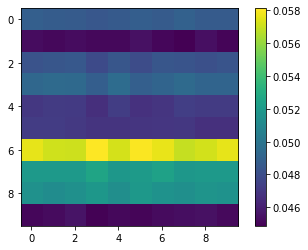

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(simmat_t_w)
plt.colorbar()
plt.show()